# 3-Layer Neural Network for Non-linear Regression (TensorFlow with Built-in Layers)

This notebook implements a 3-layer neural network using TensorFlow's built-in layers. We'll use the Keras Sequential API but still implement our own training loop to maintain control over the process. This approach provides a good balance between abstraction and control.

We'll continue to use the same 3-variable non-linear function for our synthetic dataset to maintain consistency with previous implementations.

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the function to generate synthetic data
def true_function(X):
    """
    Non-linear function with 3 variables
    X should be a matrix with 3 columns
    """
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# Generate synthetic dataset
def generate_data(n_samples=1000):
    # Generate random inputs
    X = tf.cast(tf.random.uniform((n_samples, 3), -2, 2), tf.float32)

    # Calculate true output values
    y_true = true_function(X)

    # Add some noise
    y = y_true + tf.random.normal((n_samples,), 0, 0.5)

    return X, tf.reshape(y, (-1, 1))

# Generate training data
X_train, y_train = generate_data(1000)

# Generate test data
X_test, y_test = generate_data(200)

print(f"Training data shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test data shape: X = {X_test.shape}, y = {y_test.shape}")

Training data shape: X = (1000, 3), y = (1000, 1)
Test data shape: X = (200, 3), y = (200, 1)


## Neural Network Implementation with TensorFlow Built-in Layers

Now we'll implement our 3-layer neural network using TensorFlow's built-in layers. We'll create a model using the Keras Sequential API and implement a custom training loop with TensorFlow's GradientTape.

In [2]:
# Create model using Keras layers
def create_model(input_size, hidden1_size, hidden2_size, output_size):
    # Initialize Keras Sequential model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden1_size, activation='relu', input_shape=(input_size,),
                             kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(hidden2_size, activation='relu',
                             kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(output_size, activation=None,
                             kernel_initializer=tf.keras.initializers.HeNormal())
    ])

    return model

# Create model instance
input_size = 3
hidden1_size = 10
hidden2_size = 5
output_size = 1

model = create_model(input_size, hidden1_size, hidden2_size, output_size)
model.summary()

# Define loss function
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Define the training step using gradient tape
@tf.function
def train_step(model, X, y, optimizer):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model(X, training=True)

        # Compute loss
        loss = mse_loss(y, y_pred)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

# Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop
num_epochs = 3000
batch_size = 64
print_interval = 100
losses = []

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    # Train on batches
    for X_batch, y_batch in train_dataset:
        batch_loss = train_step(model, X_batch, y_batch, optimizer)
        epoch_loss += batch_loss
        num_batches += 1

    # Average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Print progress
    if epoch % print_interval == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.6f}")

    # Store loss value
    if epoch % 10 == 0:
        losses.append(avg_loss.numpy())

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 0/3000, Loss: 8.798006
Epoch 100/3000, Loss: 0.275775
Epoch 200/3000, Loss: 0.274899
Epoch 300/3000, Loss: 0.269469
Epoch 400/3000, Loss: 0.257039
Epoch 500/3000, Loss: 0.255487
Epoch 600/3000, Loss: 0.256649
Epoch 700/3000, Loss: 0.255304
Epoch 800/3000, Loss: 0.253680
Epoch 900/3000, Loss: 0.253734
Epoch 1000/3000, Loss: 0.251130
Epoch 1100/3000, Loss: 0.255785
Epoch 1200/3000, Loss: 0.262044
Epoch 1300/3000, Loss: 0.252660
Epoch 1400/3000, Loss: 0.254948
Epoch 1500/3000, Loss: 0.252072
Epoch 1600/3000, Loss: 0.274021
Epoch 1700/3000, Loss: 0.246218
Epoch 1800/3000, Loss: 0.252128
Epoch 1900/3000, Loss: 0.253528
Epoch 2000/3000, Loss: 0.250630
Epoch 2100/3000, Loss: 0.254738
Epoch 2200/3000, Loss: 0.253201
Epoch 2300/3000, Loss: 0.251343
Epoch 2400/3000, Loss: 0.248510
Epoch 2500/3000, Loss: 0.249688
Epoch 2600/3000, Loss: 0.252155
Epoch 2700/3000, Loss: 0.246563
Epoch 2800/3000, Loss: 0.246064
Epoch 2900/3000, Loss: 0.244019
Training completed in 105.78 seconds


## Model Evaluation and Visualization

Now let's evaluate our TensorFlow model with built-in layers on the test set and visualize the training progress and predictions.

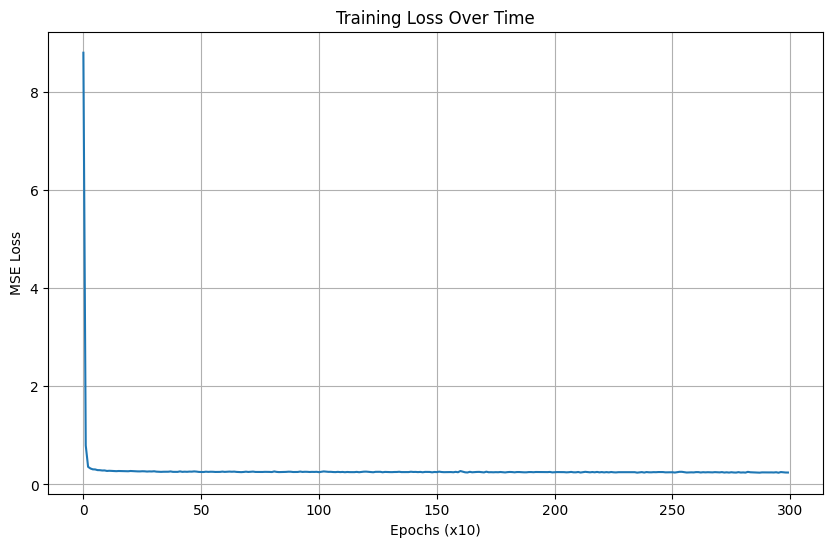

Test MSE Loss: 0.314174


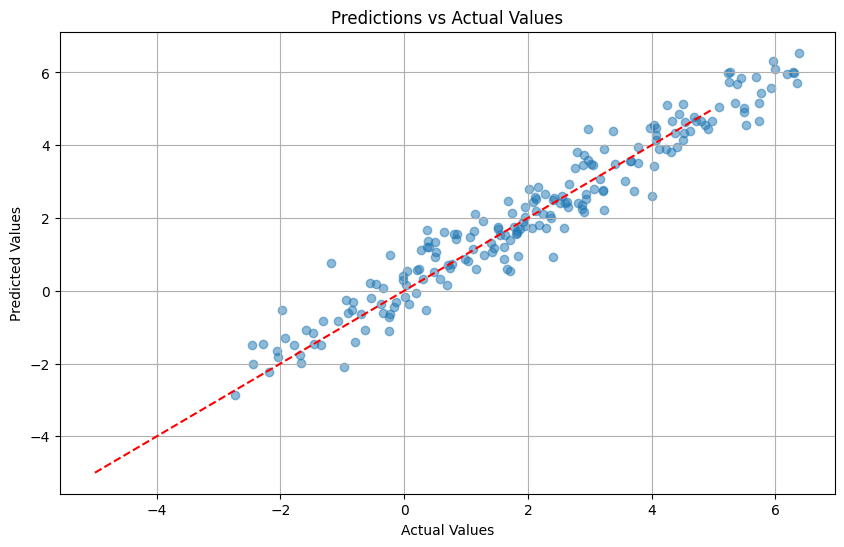

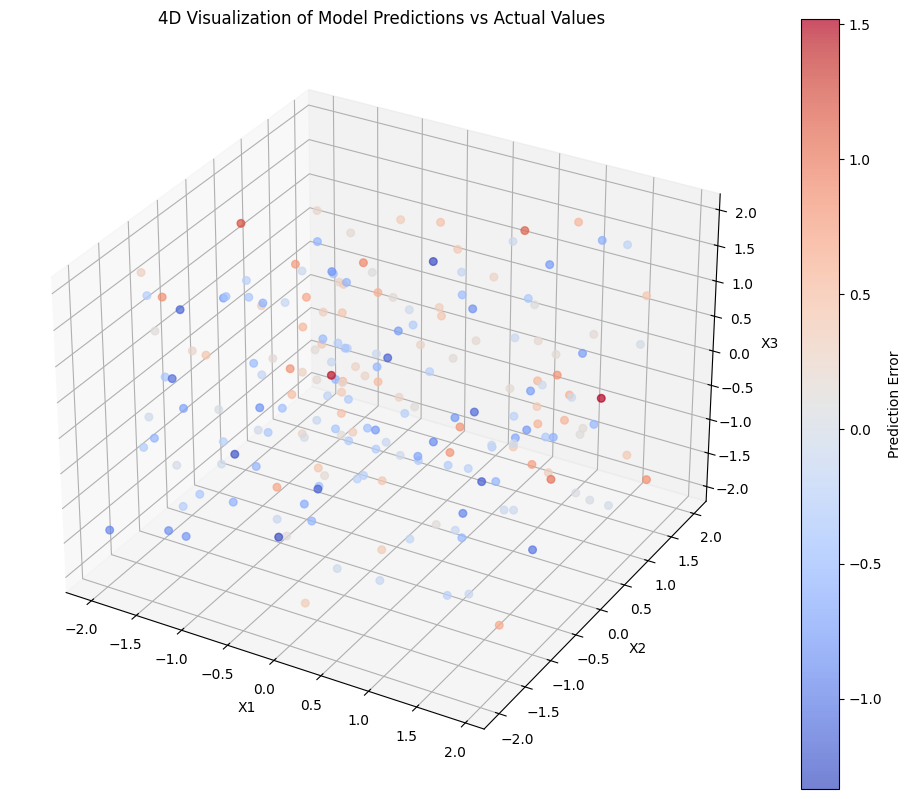

In [4]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epochs (x10)')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Evaluate on test set
y_pred_test = model(X_test)
test_loss = mse_loss(y_test, y_pred_test).numpy()
print(f"Test MSE Loss: {test_loss:.6f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test.numpy(), alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Create a 4D visualization (3D plot with color as the 4th dimension)
def visualize_4d(X, y_true, y_pred, title):
    # Convert tensors to numpy
    X_np = X.numpy()
    y_true_np = y_true.numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Create a 3D scatter plot with color as the 4th dimension
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate prediction error for coloring
    error = y_true_np - y_pred_np

    # Create the scatter plot
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error,  # Use error for coloring
                          cmap=cm.coolwarm,
                          marker='o',
                          alpha=0.7,
                          s=30)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)

    # Show the plot
    plt.show()

# Generate sample data points for visualization
X_vis, y_vis = generate_data(200)

# Get predictions for visualization
y_vis_pred = model(X_vis)

# Create 4D visualization
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Model Predictions vs Actual Values')

## 2D Slice Visualization

To better understand how our model performs across different values of our three input variables, we'll create 2D slice visualizations by fixing one variable and varying the other two.

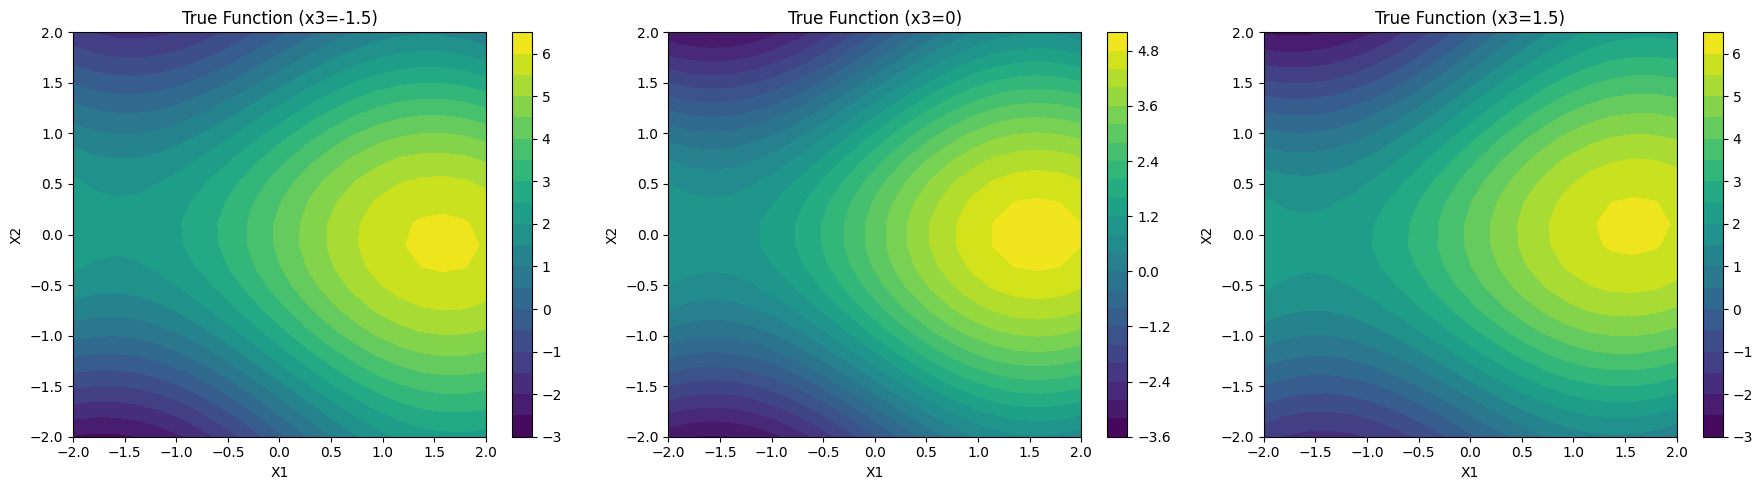

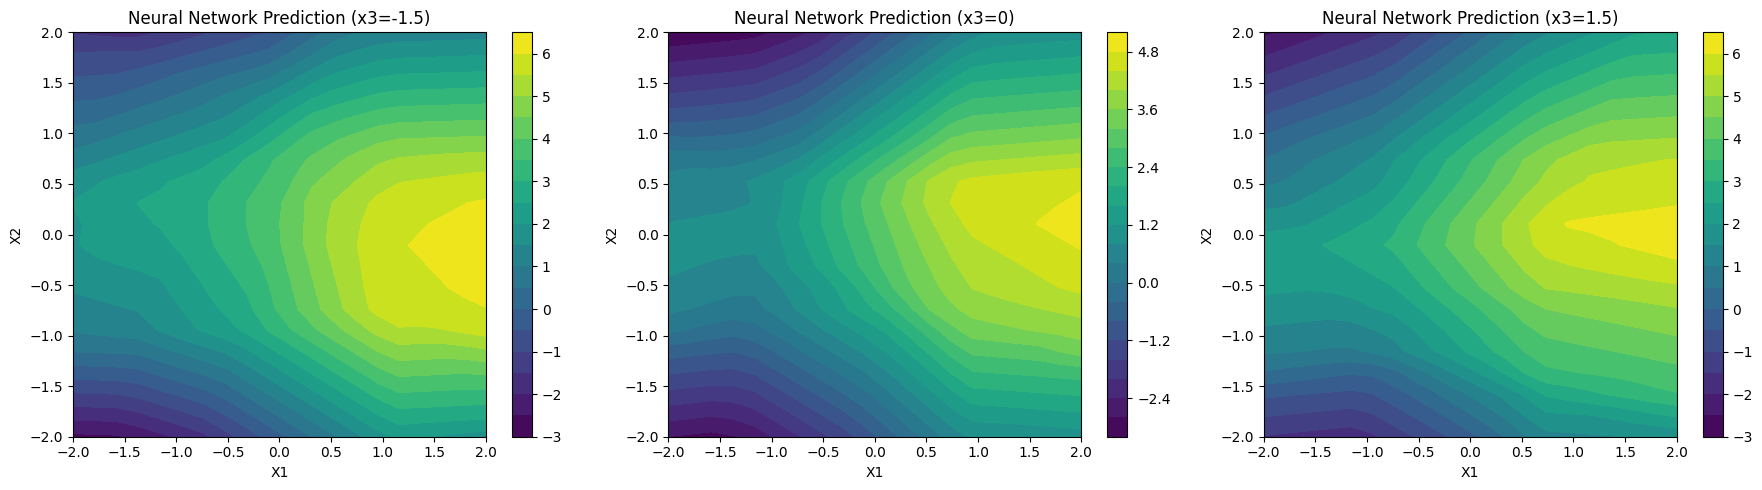

In [5]:
# Alternative visualization with 2D slices
def plot_2d_slices(X_range=2.0, grid_points=20):
    # Create a grid of points for visualization
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]  # Three fixed values for x3

    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the true function
        im1 = axes[i].contourf(X1, X2, y_true, cmap='viridis', levels=20)
        axes[i].set_title(f'True Function (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im1, ax=axes[i])

    plt.tight_layout()
    plt.show()

    # Now plot the predicted function
    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the predicted function
        im2 = axes[i].contourf(X1, X2, y_pred, cmap='viridis', levels=20)
        axes[i].set_title(f'Neural Network Prediction (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im2, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Generate and plot 2D slices
plot_2d_slices(X_range=2.0, grid_points=20)

## Summary

In this notebook, we've implemented a 3-layer neural network using TensorFlow's built-in layers. Key features of this implementation:

1. Used Keras Sequential API to create the model structure
2. Implemented proper weight initialization with He initializer
3. Used built-in ReLU activation functions
4. Created a custom training loop with fine-grained control
5. Leveraged TensorFlow's automatic differentiation with GradientTape

This implementation strikes a balance between abstraction and control. We used high-level building blocks (Keras layers) for the model definition, but maintained control over the training process through a custom training loop.

The model successfully learned to approximate our non-linear 3-variable function, with performance comparable to previous implementations. The visualizations show how well the model has learned the underlying patterns in the data.